In [1]:
import torch
from torch.autograd.functional import vjp
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from nflows import flows, transforms, distributions

from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism
from src.dimension_reduction.principal_geodesic_analysis.vector.l2_tangent_space_pca import l2TangentSpacePCAVectorSolver
from src.manifolds.euclidean.vector.pullback.standard import StandardPullbackVectorEuclidean
from src.multimodal.sum_of_diagonal_gaussian import SumOfDiagonalGaussian

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(31)

### Learning Geometry ###

/Users/wdiepeveen/Documents/Postdoc/projects/2 - Riemannian geometry-based fairness in data science/src/iso-Riemannian-geometry/.venv/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


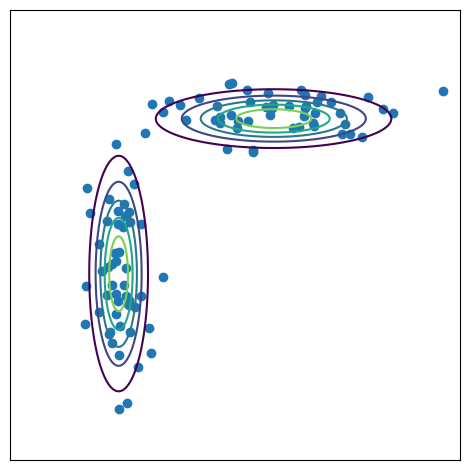

In [2]:
# Construct dataset
def multi_modal_gaussian_sampling(model, num_samples):
    def divide_number(n):
        if n % 2 == 0:
            # If the number is even, divide it equally
            return n // 2, n // 2
        else:
            # If the number is odd, make the first part one higher
            return (n + 1) // 2, (n - 1) // 2
        
    A_size, B_size = divide_number(num_samples)

    data_A = model.psi[0].offset[None] + 1 / torch.sqrt(model.psi[0].inverse_diagonal)[None] * torch.randn(A_size, 2)
    data_B = model.psi[1].offset[None] + 1 / torch.sqrt(model.psi[1].inverse_diagonal)[None] * torch.randn(B_size, 2)

    data = torch.cat([data_A, data_B], 0)

    # Generate random permutation of indices
    perm = torch.randperm(num_samples)

    # Shuffle the data tensor along the 0th axis
    return data[perm]

num_samples = 100
offset, a1, a2, w1, w2 = 5., 1/4, 4, 1, 1
double_gaussian = SumOfDiagonalGaussian(torch.tensor([[a1, a2], [a2, a1]]), torch.tensor([[-offset, 0.], [0., offset]]), torch.tensor([w1, w2]))

data_train = multi_modal_gaussian_sampling(double_gaussian, num_samples)
mean = data_train.mean(0)
data_train -= mean[None]
norm = data_train.norm(2,1).max()
data_train /= norm

train_loader = DataLoader(data_train, batch_size=16, shuffle=False)

# plot data
offset = 5

xx = torch.linspace(-6.0 - offset/2, 6.0, 500)
yy = torch.linspace(-6.0, 6.0+ offset/2 , 500)
x_grid, y_grid = torch.meshgrid(xx, yy)

xy_grid = torch.zeros((*x_grid.shape,2))
xy_grid[:,:,0] = x_grid
xy_grid[:,:,1] = y_grid

density = torch.exp(double_gaussian.log_density(xy_grid.reshape(-1,2)).reshape(x_grid.shape))
levels = torch.linspace(density.min(), density.max(), 7)  # Adjust the number of levels as needed        # Retrieve the automatically generated levels
new_levels = levels[1:]    

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data_train[:,0], data_train[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.show()

In [ ]:
def create_flow_model(dim, n_flows, hidden_dim=64):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for i in range(n_flows):
        transforms_list.append(transforms.MaskedAffineAutoregressiveTransform(features=dim, hidden_features=hidden_dim, context_features=None, num_blocks=2))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return flows.Flow(transform=flow_transforms, distribution=base_dist)

In [ ]:
# Initialize the model
dim = 2
n_flows = 2
model = create_flow_model(dim, n_flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Training loop
def train(model, train_loader, optimizer, n_epochs, lamb1=1, lamb2=1):
    for epoch in range(n_epochs):
        for batch_idx, x in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Compute loss
            loss = -model.log_prob(x).mean()

            # Add regularization
            _, log_abs_det = model._transform(x)
            log_abs_det_reg = (log_abs_det**2).mean()

            D_x_phi_T_list = []
            D_x_phi_T_list.append(vjp(lambda x: model._transform(x)[0], x, torch.eye(x.shape[1])[None].repeat(x.shape[0],1,1)[:,0])[1].unsqueeze(-1))
            D_x_phi_T_list.append(vjp(lambda x: model._transform(x)[0], x, torch.eye(x.shape[1])[None].repeat(x.shape[0],1,1)[:,1])[1].unsqueeze(-1))
            D_x_phi_T = torch.cat(D_x_phi_T_list, dim=-1)
            D_x_phi_T_D_x_phi = torch.einsum("Nik,Nkj->Nij", D_x_phi_T, D_x_phi_T)

            iso_reg = ((D_x_phi_T_D_x_phi - torch.eye(x.shape[1],x.shape[1])[None])**2).sum([1,2]).mean()

            loss += lamb1 * log_abs_det_reg + lamb2 * iso_reg
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

In [6]:
# Train the model
n_epochs = 500
train(model, train_loader, optimizer, n_epochs)

Epoch 1/500, Loss: 3.8941
Epoch 2/500, Loss: 37.5981
Epoch 3/500, Loss: 177.4265
Epoch 4/500, Loss: 58.0582
Epoch 5/500, Loss: 42.5473
Epoch 6/500, Loss: 69.3276
Epoch 7/500, Loss: 121.7044
Epoch 8/500, Loss: 132.4639
Epoch 9/500, Loss: 102.9458
Epoch 10/500, Loss: 89.7122
Epoch 11/500, Loss: 94.0292
Epoch 12/500, Loss: 99.2430
Epoch 13/500, Loss: 96.2154
Epoch 14/500, Loss: 91.5531
Epoch 15/500, Loss: 91.6645
Epoch 16/500, Loss: 92.6774
Epoch 17/500, Loss: 91.6934
Epoch 18/500, Loss: 89.7589
Epoch 19/500, Loss: 89.1548
Epoch 20/500, Loss: 88.6953
Epoch 21/500, Loss: 87.8026
Epoch 22/500, Loss: 86.3624
Epoch 23/500, Loss: 85.8158
Epoch 24/500, Loss: 85.2810
Epoch 25/500, Loss: 84.5959
Epoch 26/500, Loss: 83.4907
Epoch 27/500, Loss: 82.9438
Epoch 28/500, Loss: 82.0172
Epoch 29/500, Loss: 81.3962
Epoch 30/500, Loss: 80.5461
Epoch 31/500, Loss: 79.8827
Epoch 32/500, Loss: 79.1752
Epoch 33/500, Loss: 78.4913
Epoch 34/500, Loss: 77.6885
Epoch 35/500, Loss: 76.7812
Epoch 36/500, Loss: 75.841

In [7]:
# Generate samples
@torch.no_grad()
def generate_samples(model, n_samples):
    samples = model.sample(n_samples).cpu()
    return samples

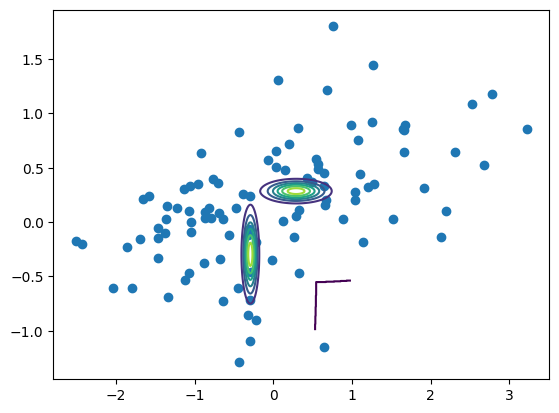

In [8]:
# Visualize generated samples
samples = generate_samples(model, 100)

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density)
plt.scatter(samples[:,0], samples[:,1])
plt.show()

In [9]:
# Construct diffeomorphism
phi = NFlowVectorDiffeomorphism(2, model)

# Construct pullback manifold
manifold = StandardPullbackVectorEuclidean(phi)

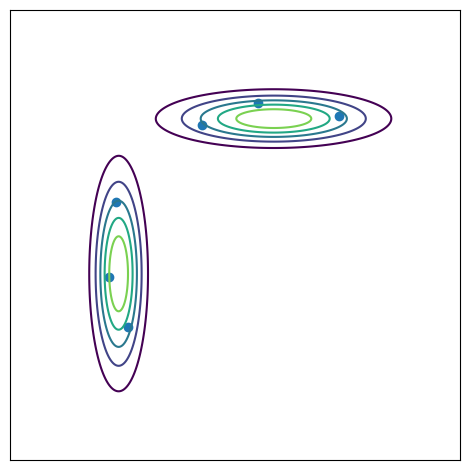

In [10]:
# special points
x0 = (torch.tensor([0.3 - offset,-1.7]) - mean)/norm
x1 = (torch.tensor([-0.3 - offset,-0.1]) - mean)/norm
x2 = (torch.tensor([-0.1 - offset,2.3]) - mean)/norm

y0 = (torch.tensor([-2.3,-0.2 + offset]) - mean)/norm
y1 = (torch.tensor([-0.5,0.5 + offset]) - mean)/norm
y2 = (torch.tensor([2.1,0.1 + offset]) - mean)/norm

data = torch.cat([x0[None], x1[None], x2[None], y0[None], y1[None], y2[None]],0)

plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-anisotropic-nflow-pullback/data.eps")
plt.show()

### Naive Riemannian data analysis ###

In [11]:
# compute geodesic
t = torch.linspace(0.,1.,20)

geodesic = manifold.geodesic(x0,y2,t).detach().numpy()

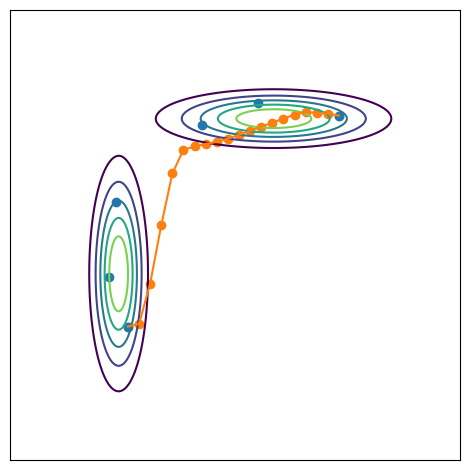

In [12]:
# plot geodesics
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.plot(geodesic[:,0], geodesic[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(geodesic[:,0], geodesic[:,1],  color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(data[:,0], data[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-anisotropic-nflow-pullback/geodesic.eps")
plt.show()

In [13]:
# compute barycentre
bary = manifold.barycentre(data.to(device)).detach().cpu()

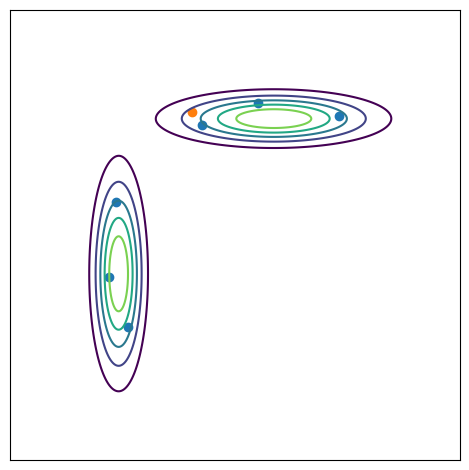

In [14]:
# plot barycentres
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-anisotropic-nflow-pullback/barycentre.eps")
plt.show()

In [15]:
# construct l2-pga solver
l2_pga_solver_bary = l2TangentSpacePCAVectorSolver(data.to(device), manifold, bary.to(device))

In [16]:
# compute low rank approximations
Xi_bary, exp_bary_Xi, _ = l2_pga_solver_bary.solve(1) # compute rank 1 approximation

Computing rank 1 approximation on tangent space
Computing rank 1 approximation on euclidean space
Computing rank 1 errors


In [17]:
# compute learned manifold
log_bary_endpoints = torch.stack([1.4 * Xi_bary[-1], 1.9 * Xi_bary[0]],dim=0)
end_points = manifold.exp(bary, log_bary_endpoints)
mfld_fit = manifold.geodesic(end_points[0], end_points[1], t).detach().cpu()

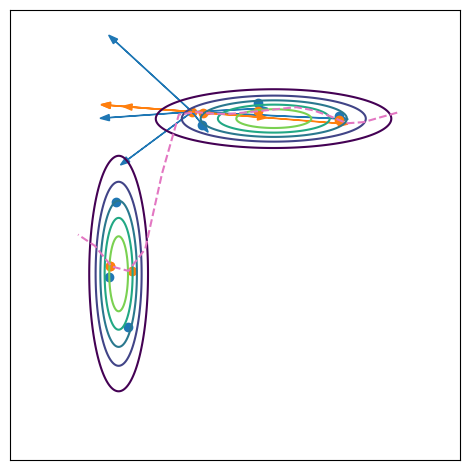

In [18]:
# plot tangent space approximations
plt.contour((x_grid - mean[0])/norm, (y_grid - mean[1])/norm, density, levels=new_levels)
plt.scatter(data[:,0], data[:,1])
plt.scatter(bary[0], bary[1])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], l2_pga_solver_bary.log_x_data[i, 0], l2_pga_solver_bary.log_x_data[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
for i in range(l2_pga_solver_bary.log_x_data.shape[0]):
    plt.arrow(bary[0], bary[1], Xi_bary[i, 0], Xi_bary[i, 1], head_width=0.2/norm, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.scatter(exp_bary_Xi[:,0], exp_bary_Xi[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.plot(mfld_fit[:,0], mfld_fit[:,1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][6], linestyle='--')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.gca().set_aspect('equal', adjustable='box')  # Ensure axes are equally spaced
plt.tight_layout()
plt.savefig("results/double_gaussian/affine-anisotropic-nflow-pullback/l2-pga.eps")
plt.show()


In [19]:
print((norm**2 * (data - exp_bary_Xi)**2).mean(0).sum().sqrt())

tensor(1.1409)
